# Summary
* Purpose: Compute resolution functions for PbTe CNCS dataset on a grid
* Procedure:
  - Simulate beam
  - Prepare sample
  - Simulate resolution
* Ei=12meV
* T=150K

* sample cylinder radius=.5cm height=3.5cm at psi=0, the orientation of the axis is [-1,0,1] (x is beam, z is vertical up). u=002, v=220

# Tools

In [1]:
pwd

u'/SNS/users/lj7/simulations/CNCS/AgBiSe2'

** Modify the workdir !!! **

In [2]:
workdir = "/SNS/users/lj7/simulations/CNCS/AgBiSe2/PbTe-try1/"
!mkdir -p {workdir}
%cd {workdir}

/SNS/users/lj7/simulations/CNCS/AgBiSe2/PbTe-try1


In [3]:
# %matplotlib notebook
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np, os, glob
import histogram.hdf as hh, histogram as H

In [4]:
!which mcvine

/home/lj7/dv/mcvine/export/bin/mcvine


In [5]:
import mcvine.cli

In [6]:
from dgsres.singlextal import use_res_comps
reload( use_res_comps )

<module 'dgsres.singlextal.use_res_comps' from '/home/lj7/dv/mcvine/export/lib/python2.7/site-packages/dgsres/singlextal/use_res_comps.pyc'>

# Beam

was already simulated in PbTe-explore-one-point.ipynb

# Sample

was already created in PbTe-explore-one-point.ipynb

In [8]:
cat {workdir}/sample.yaml

name: PbTe
chemical_formula: PbTe
lattice: 
 constants: 6.461, 6.461, 6.461, 90, 90, 90
 basis_vectors:
  - 6.461, 0, 0
  - 0, 6.461, 0
  - 0, 0, 6.461
excitations:
 - type: DGSresolution
orientation:
 u: 0, 0, 2
 v: 2, 2, 0
shape: |
       <rotation angles="-45.*deg, 0.*deg, 0.*deg">
         <cylinder radius=".5*cm" height="3.5*cm"/>
       </rotation>
temperature: 100*K

In [17]:
sampleyml = os.path.join(workdir, 'sample.yaml')

# CNCS Instrument

In [9]:
beam = "/SNS/users/lj7/simulations/CNCS/AgBiSe2/PbTe-try1/beam/"
instrument = use_res_comps.instrument(
    name = 'CNCS',
    detsys_radius = "3.5*meter",
    L_m2s = "36.264*meter",
    offset_sample2beam = "-0.15*meter" # offset from sample to saved beam
    )
pixel = use_res_comps.pixel(
    radius = "0.5*inch",
    height = "2.*meter/128",
    pressure = "6*atm",
    )

# psi scan

In [10]:
class psi_scan:
    min = -74.
    max = 50.
    step = 1.

# mcvine simulation

In [11]:
cd {workdir}

/SNS/users/lj7/simulations/CNCS/AgBiSe2/PbTe-try1


** Define projection direction and starting point **

In [12]:
hkl_projection = np.array([1,1,0])

In [13]:
hkl0 = np.array([0,0,4])
hkl0

array([0, 0, 4])

** Define points of interest **

In [14]:
E_arr = np.arange(-6, 6, 2.)
q_arr = np.arange(-2, 2, 0.5)

In [20]:
valid_pairs = []
for E in E_arr:
    for q in q_arr:
        hkl = hkl0 + hkl_projection*q
        dir1 = 'sim-q%s-E%s' % (q,E)
        try:
            use_res_comps.setup(
                dir1,
                sampleyml, beam, E, hkl, hkl_projection,
                psi_scan, instrument, pixel)
        except:
            continue
        valid_pairs.append((q,E))
        continue
    continue

Ei=12.1196524, t0=136.433557094
Computed:
* psi=4.50285915816 degree
* Q=[  4.09385379e+00  -2.43670268e+00   4.10686751e-16]
* hkl2Qmat=[[ -5.39863181e-02   6.85523853e-01  -6.87646330e-01]
 [ -5.39863181e-02   6.85523853e-01   6.87646330e-01]
 [  9.69477130e-01   7.63481833e-02  -8.35061464e-18]]
* ki=2.41845180576
* vectors ki=[ 2.41845181  0.          0.        ], kf=[ -1.67540199e+00   2.43670268e+00  -4.10686751e-16]
These two numbers should be very close:
  -6.0
  -6.0
  Ei=12.1196524, Ef=18.1196524
* Ef=18.1196524
* pixel positon=[ -1.98298662e+00   2.88405341e+00  -4.86084140e-16]
* pixel_position=[ -1.98298662e+00   2.88405341e+00  -4.86084140e-16]
t_m2s=0.0239518666718, t_s2p=0.00187984037657, t_m2p=0.0258317070484
Ei=12.1196524, t0=136.433557094
Computed:
* psi=-11.3154586494 degree
* Q=[  3.40953122e+00  -2.78608208e+00  -3.10183332e-16]
* hkl2Qmat=[[  1.34923575e-01   6.74279693e-01  -6.87646330e-01]
 [  1.34923575e-01   6.74279693e-01   6.87646330e-01]
 [  9.53575486e-01

In [22]:
len(valid_pairs)

44

** add MC parameter file **

In [26]:
cat test/mc_params.yml

Nbuffer: 100000
Nrounds_beam: 10

In [23]:
import shutil

In [25]:
for q,E in valid_pairs:
    dir1 = 'sim-q%s-E%s' % (q,E)
    shutil.copyfile('./test/mc_params.yml', os.path.join(dir1, 'mc_params.yml'))
    continue

** Create script to run all sims **

using 20 cores

In [35]:
path = 'run-sims.sh'
with open(path, 'wt') as ostream:
    ostream.write('parallel --max-procs 20 << EOF\n')
    for q,E in valid_pairs:
        dir1 = 'sim-q%s-E%s' % (q,E)
        ostream.write('cd %s && python run.py &>log.run\n' % os.path.abspath(dir1))
        continue
    ostream.write('EOF\n')

In [40]:
!chmod +x run-sims.sh

In [38]:
#cat run-sims.sh

** Run simulation. This will take 30~60minutes **

In [42]:
%%bash
./run-sims.sh

In [45]:
ls sim*/res.h5 |wc -l

44


# Plot resolution functions

In [125]:
from dgsres.singlextal import fit2icg
reload(fit2icg)

from dgsres import icg
reload(icg)

<module 'dgsres.icg' from '/home/lj7/dv/mcvine/export/lib/python2.7/site-packages/dgsres/icg.pyc'>

In [52]:
cncs_geom = icg.Geom(l1=6.413, l2=36.2-6.413, l3=3.5)

In [54]:
Ei = 12

In [59]:
q_arr

array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5])

In [60]:
E_arr

array([-6., -4., -2.,  0.,  2.,  4.])

Load data

In [126]:
%%time
Nq = len(q_arr)
NE = len(E_arr)
fitters = dict()
for iq, q in enumerate(q_arr):
    for iE, E in enumerate(E_arr[::-1]):
        if (q,E) not in valid_pairs:
            continue
        print (q,E)
        dir1 = 'sim-q%s-E%s' % (q,E)
        fitter = fit2icg.Fit2ICG(dir1, cncs_geom, qaxis=(-0.3, 0.3, 0.002), Eaxis=(-3, 2, 0.02), Ei=Ei, E=E)
        fitters[(q,E)] = fitter
        fitter.load_mcvine_psf_qE()
        continue
    continue

(-2.0, 0.0)
(-2.0, -2.0)
(-2.0, -4.0)
(-2.0, -6.0)
(-1.5, 2.0)
(-1.5, 0.0)
(-1.5, -2.0)
(-1.5, -4.0)
(-1.5, -6.0)
(-1.0, 4.0)
(-1.0, 2.0)
(-1.0, 0.0)
(-1.0, -2.0)
(-1.0, -4.0)
(-1.0, -6.0)
(-0.5, 4.0)
(-0.5, 2.0)
(-0.5, 0.0)
(-0.5, -2.0)
(-0.5, -4.0)
(-0.5, -6.0)
(0.0, 4.0)
(0.0, 2.0)
(0.0, 0.0)
(0.0, -2.0)
(0.0, -4.0)
(0.0, -6.0)
(0.5, 4.0)
(0.5, 2.0)
(0.5, 0.0)
(0.5, -2.0)
(0.5, -4.0)
(0.5, -6.0)
(1.0, 4.0)
(1.0, 2.0)
(1.0, 0.0)
(1.0, -2.0)
(1.0, -4.0)
(1.0, -6.0)
(1.5, 2.0)
(1.5, 0.0)
(1.5, -2.0)
(1.5, -4.0)
(1.5, -6.0)
CPU times: user 17.5 s, sys: 6.48 s, total: 24 s
Wall time: 25.1 s


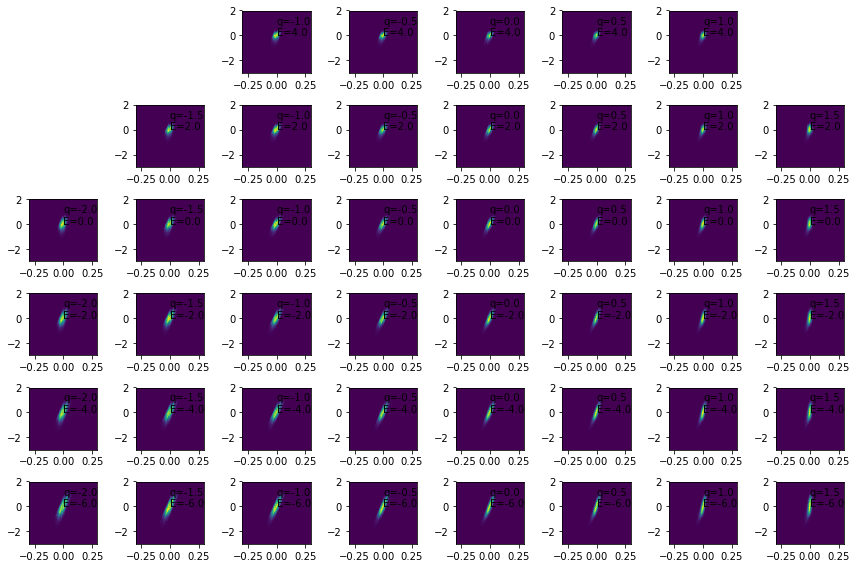

In [117]:
plt.figure(figsize=(12, 8))
for iq, q in enumerate(q_arr):
    for iE, E in enumerate(E_arr[::-1]):
        if (q,E) not in valid_pairs:
            continue
        # print (q,E)
        ax=plt.subplot(NE, Nq, iE*Nq+iq+1)
        fitter = fitters[(q,E)]
        hist = fitter.mcvine_psf_qE
        qgrid, Egrid = fitter.qEgrids
        plt.pcolormesh(qgrid, Egrid, hist.I.T, cmap='viridis')
        ax.text(0,0, "q=%s\nE=%s" % (q,E))
        continue
    continue
plt.tight_layout()

# Fit

[ 1.57789505  0.2         0.01        4.71323938  2.        ]


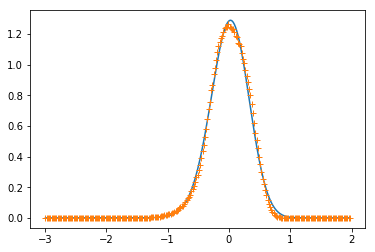

In [141]:
fitter = fitters[(0., 0.)]
# fitted_params, res_x, res_y, yfit, E_profile = fitter.fit_E_profile(a=0.35, b=0.13, R=.8, sigma=2, t0=15)
fitted_params, res_x, res_y, yfit, E_profile = fitter.fit_E_profile(
    a=(0.2, 2.), b=(0.02, 0.2), R=(.01, .6), sigma=(1,20.), t0=(2, 40))
print fitted_params
plt.figure()
plt.plot(res_x, yfit)
# plt.plot(res_x, E_profile(res_x))
plt.plot(res_x, res_y, '+')

/home/lj7/dv/mcvine/export/lib/python2.7/site-packages/dgsres/icg.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  return 1./l/sq2/sqp/sigma*((1-R)*a*a*C2_a + R*a*a*b/(a-b)**3*(2*C0_b-((a-b)**2*C2_a+2*(a-b)*C1_a+2*C0_a)))
/home/lj7/dv/mcvine/export/lib/python2.7/site-packages/dgsres/icg.py:57: RuntimeWarning: invalid value encountered in multiply
  return 1./l/sq2/sqp/sigma*((1-R)*a*a*C2_a + R*a*a*b/(a-b)**3*(2*C0_b-((a-b)**2*C2_a+2*(a-b)*C1_a+2*C0_a)))
/home/lj7/dv/mcvine/export/lib/python2.7/site-packages/dgsres/singlextal/fit2icg.py:173: RuntimeWarning: invalid value encountered in divide
  self.a = a


25000.0
25000.0


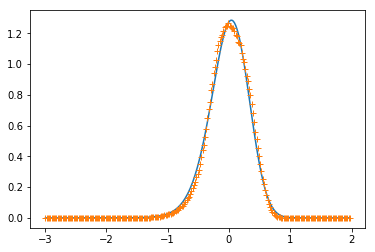

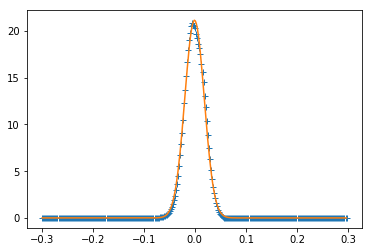

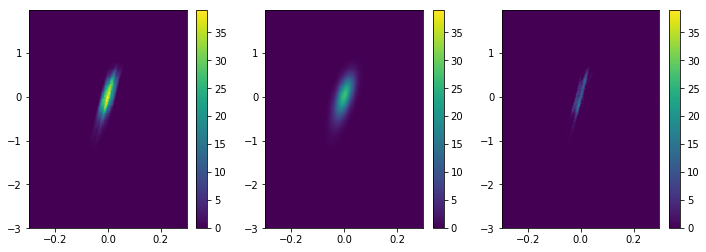

In [127]:


popt, res_x, res_y, yfit, q_profile = fitter.fit_q_profile(sigma=0.1)
plt.figure()
plt.plot(res_x, res_y, '+')
plt.plot(res_x, yfit)

fitted_parameters, qgrid, Egrid, res_z, zfit, qE_profile = fitter.fit_qE_profile(dq_over_dE=0.02)
print np.sum(res_z)
print np.sum(zfit)
diff = res_z - zfit

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.pcolormesh(qgrid, Egrid, res_z, cmap='viridis')
plt.colorbar()
plt.subplot(1,3,2)
plt.pcolormesh(qgrid, Egrid, zfit, cmap='viridis')
plt.clim(0, np.max(res_z))
plt.colorbar()
plt.subplot(1,3,3)
plt.pcolormesh(qgrid, Egrid, diff, cmap='viridis')
plt.clim(0, np.max(res_z))
plt.colorbar()

In [145]:
%%time
model_params = dict()
for q,E in valid_pairs:
    print q,E
    fitter = fitters[(q, E)]
    # E_fitted_params, res_x, res_y, yfit, E_profile = fitter.fit_E_profile(a=0.35, b=0.13, R=.8, sigma=2, t0=15)
    E_fitted_params, res_x, res_y, yfit, E_profile = fitter.fit_E_profile(
        a=(0.35, 0.5), b=(0.15, 0.2), R=(.02, .04), sigma=(3,4.6), t0=(5, 8))
    #a=(0.2, 0.5), b=(0.02, 0.2), R=(.01, .6), sigma=(1,20.), t0=(2, 40))
    popt, res_x, res_y, yfit, q_profile = fitter.fit_q_profile(sigma=0.1)
    q_sigma = popt[-1]
    qE_fitted_params, qgrid, Egrid, res_z, zfit, qE_profile = fitter.fit_qE_profile(dq_over_dE=0.02)
    dq_over_dE = qE_fitted_params[0]
    a,b,R,sigma,t0 = E_fitted_params
    model_params[(q,E)] = dict(
        a=a, b=b, R=R, sigma=sigma, t0=t0,
        q_sigma = q_sigma,
        dq_over_dE = dq_over_dE,
    )
    continue

-2.0 -6.0
-1.5 -6.0
-1.0 -6.0
-0.5 -6.0
0.0 -6.0
0.5 -6.0
1.0 -6.0
1.5 -6.0
-2.0 -4.0
-1.5 -4.0
-1.0 -4.0
-0.5 -4.0
0.0 -4.0
0.5 -4.0
1.0 -4.0
1.5 -4.0
-2.0 -2.0
-1.5 -2.0
-1.0 -2.0
-0.5 -2.0
0.0 -2.0
0.5 -2.0
1.0 -2.0
1.5 -2.0
-2.0 0.0
-1.5 0.0
-1.0 0.0
-0.5 0.0
0.0 0.0
0.5 0.0
1.0 0.0
1.5 0.0
-1.5 2.0
-1.0 2.0
-0.5 2.0
0.0 2.0
0.5 2.0
1.0 2.0
1.5 2.0
-1.0 4.0
-0.5 4.0
0.0 4.0
0.5 4.0
1.0 4.0
CPU times: user 10.7 s, sys: 80 ms, total: 10.8 s
Wall time: 10.7 s


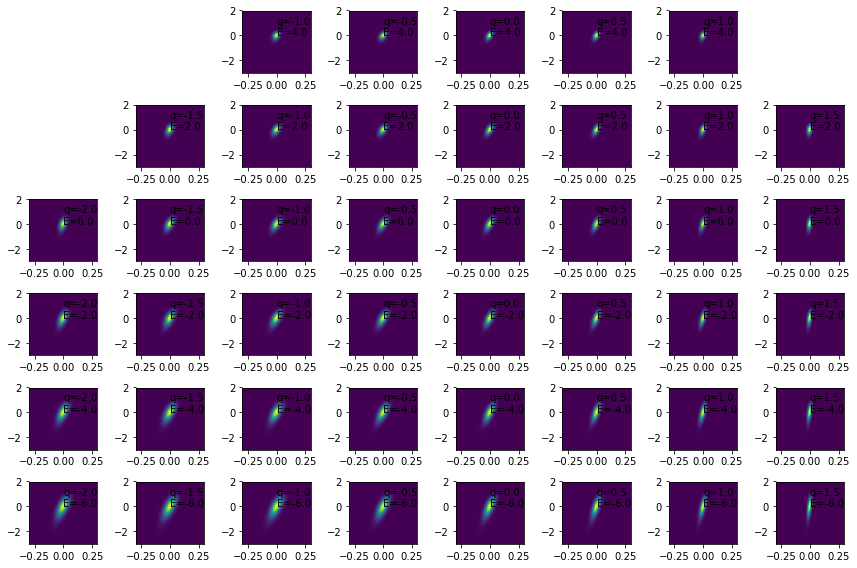

In [143]:
plt.figure(figsize=(12, 8))
for iq, q in enumerate(q_arr):
    for iE, E in enumerate(E_arr[::-1]):
        if (q,E) not in valid_pairs:
            continue
        # print (q,E)
        ax=plt.subplot(NE, Nq, iE*Nq+iq+1)
        fitter = fitters[(q,E)]
        qgrid, Egrid = fitter.qEgrids
        I = fitter.model.qE_profile(qgrid, Egrid)
        # print np.min(I), np.max(I), np.isnan(I).sum()
        plt.pcolormesh(qgrid, Egrid, I, cmap='viridis')
        ax.text(0,0, "q=%s\nE=%s" % (q,E))
        continue
    continue
plt.tight_layout()

# Interpolation

In [146]:
model_params

{(-2.0, -6.0): {'R': 0.02,
  'a': 0.5,
  'b': 0.20000000000000001,
  'dq_over_dE': 0.041570561818081213,
  'q_sigma': 0.027102026809677951,
  'sigma': 3.3751984021545631,
  't0': 5.0311042384033939},
 (-2.0, -4.0): {'R': 0.02,
  'a': 0.5,
  'b': 0.20000000000000001,
  'dq_over_dE': 0.03977439574637065,
  'q_sigma': 0.024419241674164927,
  'sigma': 3.5104489364804041,
  't0': 5.0712725188624299},
 (-2.0, -2.0): {'R': 0.02,
  'a': 0.5,
  'b': 0.20000000000000001,
  'dq_over_dE': 0.035706366377505801,
  'q_sigma': 0.021646790689277263,
  'sigma': 3.6831510280994633,
  't0': 5.1338048927111863},
 (-2.0, 0.0): {'R': 0.02,
  'a': 0.5,
  'b': 0.20000000000000001,
  'dq_over_dE': 0.026111952537217147,
  'q_sigma': 0.018615754774885626,
  'sigma': 3.9534634067416614,
  't0': 5.27315120152109},
 (-1.5, -6.0): {'R': 0.02,
  'a': 0.5,
  'b': 0.20000000000000001,
  'dq_over_dE': 0.044889511679880631,
  'q_sigma': 0.027868259099382245,
  'sigma': 3.3771913767112141,
  't0': 5.0294462337988213},
 (-1

In [147]:
def build_z(name):
    return [model_params[key][name] for key in valid_pairs]

In [152]:
qs, Es = np.array(valid_pairs).T

In [149]:
import scipy.interpolate as si

In [158]:
interps = dict()
names = 'R a b sigma t0 q_sigma dq_over_dE q_sigma'.split()
for name in names:
    interps[name] = si.interp2d(qs, Es, build_z(name), kind='linear')
    continue

/home/lj7/miniconda2/envs/dev-mcvine/lib/python2.7/site-packages/scipy/interpolate/_fitpack_impl.py:975: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=7,11 m=44 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/lj7/miniconda2/envs/dev-mcvine/lib/python2.7/site-packages/scipy/interpolate/_fitpack_impl.py:975: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=9,9 m=44 fp=0.000118 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/lj7/miniconda2/envs/dev-mcvine/lib/python2.7/site-packages/scipy/interpolate/_fitpack_impl.py:975: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds t

In [165]:
interps['dq_over_dE'](0,0)

array([ 0.04415199])

In [167]:
import copy

In [169]:
model = copy.copy(fitter.model)
qgrid, Egrid = fitter.qEgrids

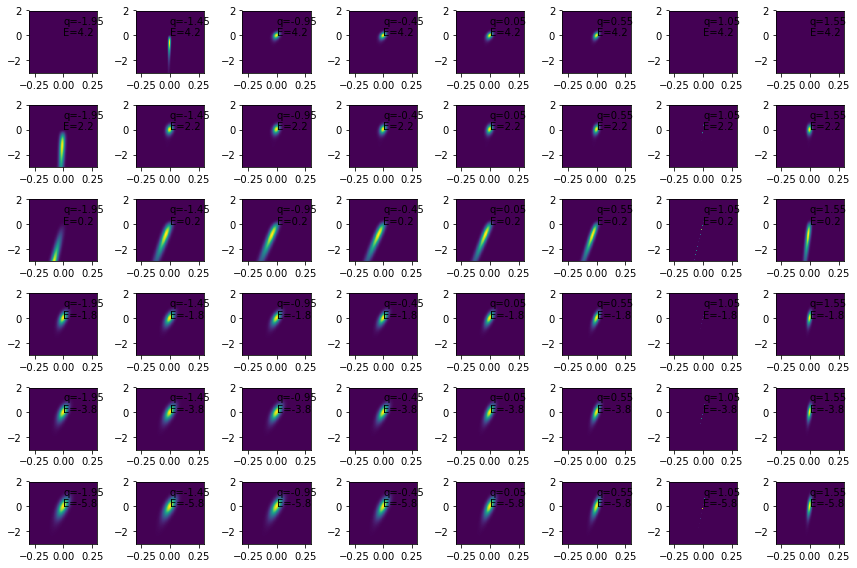

In [172]:
plt.figure(figsize=(12, 8))
for iq, q in enumerate(q_arr+.05):
    for iE, E in enumerate(E_arr[::-1]+.2):
        # print (q,E)
        ax=plt.subplot(NE, Nq, iE*Nq+iq+1)
        # compute interped values
        v = dict()
        for name in names:
            v[name] = interps[name](q, E)
            continue
        model.E = E
        model.set_E_profile(v['a'], v['b'], v['R'], v['sigma'], v['t0'])
        model.set_q_profile(v['q_sigma'])
        model.set_qE_profile(v['dq_over_dE'])
        I = model.qE_profile(qgrid, Egrid)
        # print np.min(I), np.max(I), np.isnan(I).sum()
        plt.pcolormesh(qgrid, Egrid, I, cmap='viridis')
        ax.text(0,0, "q=%s\nE=%s" % (q,E))
        continue
    continue
plt.tight_layout()